#Table of Contents
* [Basic Filtering](#Basic-Filtering)
	* [Introduction](#Introduction)
	* [Analysis of the data](#Analysis-of-the-data)
		* [Filtering](#Filtering)
	* [Design and implementation of the lowpass averaging filter](#Design-and-implementation-of-the-lowpass-averaging-filter)
		* [Theoretical part:](#Theoretical-part:)
		* [Practical part](#Practical-part)
	* [Computation of the subtracting filter](#Computation-of-the-subtracting-filter)
	* [Second part: Boost of a frequency band](#Second-part:-Boost-of-a-frequency-band)
		* [Pratical part](#Pratical-part)
	* [Lowpass [0- 250 Hz] filtering  by the window method](#Lowpass-[0--250-Hz]-filtering--by-the-window-method)
		* [Theoretical Part](#Theoretical-Part)
		* [Practical part](#Practical-part)
		* [Output of the lowpass filter](#Output-of-the-lowpass-filter)
		* [Group Delay](#Group-Delay)


In [48]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools', 'calico-cell-tools');

In [8]:
%run nbinit.ipy
js_addon()


... Configuring matplotlib formats
... Configuring matplotlib with inline figures
... Importing numpy as np, scipy as sp, pyplot as plt, scipy.stats as stats
   ... scipy.signal as sig
... Importing widgets, display, HTML, Image, Javascript
... Loading customized Javascript for LaTeX typesetting
... Some LaTeX definitions


... Defining figures captions 


... Loading customized Javascript for interactive solutions (show/hide)
Overriding run-range javascript function


In [9]:
%run interactive_sols.ipy

Overriding run-range javascript function


# Lab -- Basic Filtering


Author: [J.-F. Bercher](http://www.esiee.fr/~bercherj) <br>
date: november 19, 2013 <br>
Update: february 25, 2014 <br>
Last update: december 08, 2014

## Introduction

>The goal of this lab is to study and apply several digital filters to a periodic signal with fundamental frequency $f_{0}$=200 Hz, sampled at frequency $F_{s}$=8000 Hz. This signal is corrupted by a low drift, and that is a common problem with sensor measurements. A first filter will be designed in order to remove this drift. In a second step, we will boost a frequency range withing the components of this signal. Finally, we will consider the design of a simple low-pass filter using the window method, which leads to a linear-phase filter. 
>
>This signal is contained into the vector $x$ stored in the file
[sig1.npz](sig1.npz). It is possible to load it via the instruction 
`f=np.load('sig1.npz')`



In [7]:
Fs=8000
Ts=1/Fs

First load all useful modules:

In [46]:
import numpy as np
from numpy import ones, zeros, abs, exp, pi, sin, real, imag
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import lfilter
from numpy.fft import fft, ifft, fftshift

%matplotlib inline

## Analysis of the data

In [6]:
# utilitary function
def freq(N,Fs=1):
    """ Returns a vector of size N  of normalized frequencies
    between -Fs/2 and Fs/2 """
    return np.linspace(-0.5,0.5,N)*Fs

For the record, the following lines enable to read a Matlab `.mat` file and save the data in the NumPy format

    mat = scipy.io.loadmat('sig1.mat') # Actually mat is a dict
    mat.keys()   # whose keys are given by  .keys()
    x=mat['x'].flatten()
    m=mat['m'].flatten()
    ## We save data using the compressed numpy format
    numpy.savez('sig1',x=x, m=m)

In [ ]:
# To load the signal
sig1=np.load('sig1.npz')
#sig1 is a dictionnary. One can look at the keys by: sig1.keys()
m=sig1['m']
x=sig1['x']


>We can plot the signal, in time and frequency, by the following lines

>      # Loading 
>
    sig1=np.load('sig1.npz')
    #sig1 is a dictionnary. One can look at the keys by: sig1.keys()
    m=sig1['m']
    x=sig1['x']
>
    Fs=8000
    Ts=1/Fs
>
>     # Time representation
    plt.figure(1)
    t=np.np.arange(len(x))*Ts
    plt.plot(t,x,t,m)
    plt.title('Signal with slow drift')
    plt.show()
>and
>
    # Frequency representation
    plt.figure(2)
    N=len(x)
    f=freq(N)
    plt.plot(f,abs(fftshift(fft(x))))
    plt.xlim([-0.5, 0.5])
    plt.title('Fourier transform of the signal (modulus)')
>   
>
>Analyze and comment these figures. 


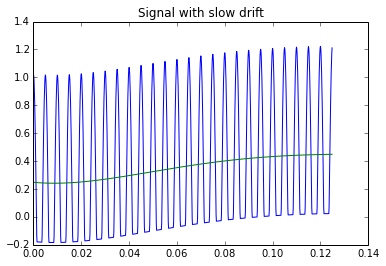

In [13]:
# Time
plt.figure(1)
t=np.arange(len(x))*Ts
plt.plot(t,x,t,m)
plt.title('Signal with slow drift')
plt.show()

We observe an approximately periodic time series, with period  ~ 40, and a slow drift of the mean value

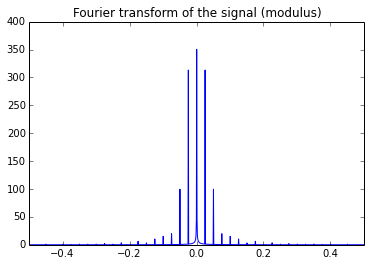

In [21]:

# Frequency representation
plt.figure(2)
N=len(x)
f=freq(N)
plt.plot(f,np.abs(fftshift(fft(x))))
plt.xlim([-0.5, 0.5])
plt.title('Fourier transform of the signal (modulus)')
plt.show()

We see that the Fourier transform consists of a series of regularly spaced spectral lines, which is the indication that the underlying signal is periodic. The peaks are spaced-out by 0.025, in normalized frequencies. This effectively corresponds to a period of 40 observed on the time representation.

### Filtering

>We wish now to modify the spectral content of $x$ using different digital filters with transfer function 
$H(z)=B(z)/A(z)$. A standard Python function will be particularly useful: 
>
>- *lfilter* implements the associated difference equation. This function computes the output vector $y$ of the digital filter specified by 
  * the vector $B$ (containing the coefficients of the numerator  $B(z)$, 
  * and by the vector $A$ of the denominator's coefficients  $A(z)$, 
for an input vector $x$:
`y=lfilter(B,A,x)`
>
>- *freqz* computes the frequency response 
$H$(e$^{j2\pi f / Fs})$ in modulus and phase, for a filter described by the two vectors $B$ and $A$: 
`freqz(B,A)`

## Design and implementation of the lowpass averaging filter

>The signal is corrupted by a slow drift of its mean value. We look for a way to extract and then  remove this drift. We will denote $M(n)$ the drift, and $x_c(n)$ the centered (corrected) signal.

### Theoretical part:

>What analytical expression enable to compute the signal's mean <u>on a period</u>?
>
>From that, deduce a filter with impulse response $g(n)$ which computes this mean $M(n)$.
>
>Find another filter, with impulse response $h(n)$, removes this mean: $x_{c}(n)= x(n) - M(n) = x(n) *  h(n)$. Give the expression of $h(n)$.
>
>Also give the analytical expressions of  $G(z)$ and $H(z)$. 

### Practical part

>For the averaging filter and then for the subtracting filter:

>- Compute and plt.plot the two impulse responses (you may use the instruction `ones(L)` which returns a vector of  $L$ ones.

>- plt.plot the frequency responses of these two filters. You may use  the function `fft` which returns the Fourier transform, and plt.plot the modulus `abs` of the result.

>- Filter  $x$ by these two filters. plt.plot the output signals, in the time and frequency domain. Conclude. 

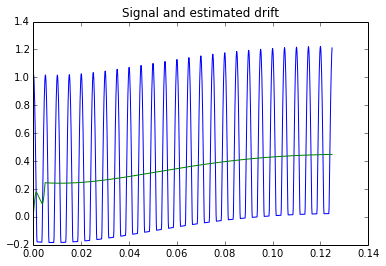

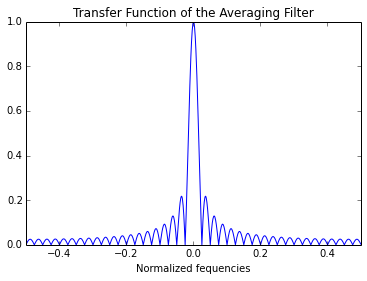

In [23]:
# Averaging filter
#-----------------------------------------------------------
# Filter g which computes the mean on a period of 40 samples
L=40
g=np.ones(L)/L
m_estimated=lfilter(g,1,x)
plt.figure(3)
plt.plot(t,x,t,m_estimated)
plt.title('Signal and estimated drift')
plt.show()
#
# We check G(f)
G=fftshift(fft(g,1000))
plt.figure(4)
plt.plot(freq(1000),abs(G))
plt.xlim([-0.5, 0.5])
plt.xlabel('Normalized fequencies')
plt.title('Transfer Function of the Averaging Filter')

We shall note, and this is very nice, that this Fourier transform has the the good idea to cancel out every  $1/L$: Thus the peaks in the frequency representation of the  periodic signal are perfectely removed. It only reamins the frequency part around $f=0$.

## Computation of the subtracting filter

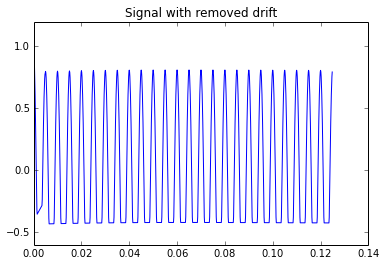

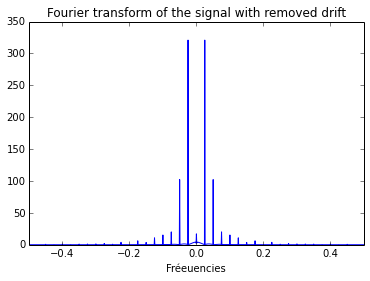

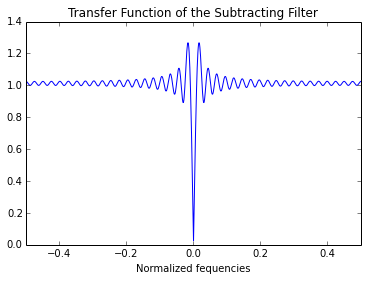

In [25]:
# Mean subtracting filter
#-----------------------------------------------------------
# The filter h subtract the mean computed over a sliding window of 40 samples
# h may be defined as 
h=-np.ones(L)/L
h[0]=1
# or via the operation
# $xc(n)=x(n)-(g*x)(n)$
xc=lfilter(h,1,x)
plt.figure(5)
plt.plot(t,xc)
plt.title('Signal with removed drift')
plt.show()

plt.figure(6)
plt.plot(freq(len(xc)),abs(fftshift(fft(xc))))
plt.xlabel('Fréeuencies')
plt.xlim([-0.5, 0.5])
plt.title('Fourier transform of the signal with removed drift')
plt.show()

#We check H(f)
H=fftshift(fft(h,1000))
plt.figure(7)
plt.plot(freq(1000),abs(H))
plt.xlabel('Normalized fequencies')
plt.xlim([-0.5, 0.5])
plt.title('Transfer Function of the Subtracting Filter')

## Second part: Boost of a frequency band

>We wish now to boost a range of freqencies aound 1000 Hz on the initial signal. 
>
>## Theoretical Part
>
>After a (possible) recall of the lecturer on rational filters, compute the poles $p_{1}$ and $p_{2}$ of a filter in order to perform this accentuation. Compute the transfer function $H(z)$ and the associated impulse response  $h(n)$. 

In [3]:
show_solution(1)

**Answer**: Derivation of the impulse response by selecting a pair of complex conjugated poles for the frequency of interest.
The theoretical impulse response can be computed as follows: Consider a transfer function with two poles $p_{0}$ and $p_{1}$:

$H(z)=\frac{1}{\left(1-p_{0}z^{-1}\right)\left(1-p_{1}z^{-1}\right)}$

By Heaviside partial-fraction expansion, we have
$$
H(z)=\frac{A}{1-p_{0}z^{-1}}+\frac{B}{1-p_{1}z^{-1}}
$$
 with $A=\frac{p_{0}}{p_{0}-p_{1}}$ and $B=-\frac{p_{1}}{p_{0}-p_{1}}$.
We thus have
$$
H(z)=\frac{1}{p_{0}-p_{1}}\left(\frac{p_{0}}{1-p_{0}z^{-1}}-\frac{p_{1}}{1-p_{1}z^{-1}}\right)
$$


The inverse z-transform of
$1/(1-az^{-1})$ is $a^{n}u(n)$, where $u(n)$ is the Heaviside step function.
Therefore, we get that
$$
h(n)=\frac{1}{p_{0}-p_{1}}\left(p_{0}^{n+1}-p_{1}^{n+1}\right)u(n).
$$
 Finally, if we take two complex conjugated poles
$p_{0}=p_{1}^{*}=\rho e^{j2\pi f_{0}},$ it comes
$$
h(n)=\rho^{n}\,\frac{\sin(2\pi(n+1)f_{0})}{\sin(2\pi f_{0})}\, u(n).
$$



### Pratical part

>- The vector of denominator's $A(z)$ coefficients will be computed according to `A=poly([p1,p2])`, and you will check that you recover the hand-calculated coefficients.
>
>- plt.plot the frequency response
>
>- Compute the impulse response, according to 
        # computing the IR
        d=zeros(300)
        d[1]=1
        h_accentued=lfilter([1],a,d)
(output to a Dirac impulse on 300 point). plot it. 
>
>- Compute and plot the impulse response obtained using the theoretical formula. Compare it to the simulation. 
>
>-  Compute and plot the output of the filter with input $x_{c}$, both in the time and frequency domain. Conclude. 

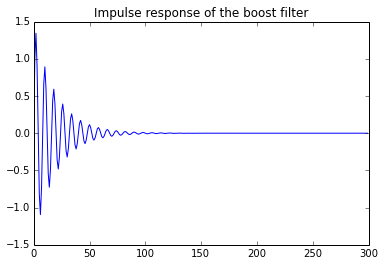

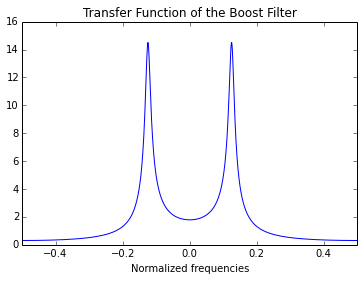

In [32]:
rho=0.95
fo, Fs=1000, 8000
a=np.poly([rho*exp(1j*2*pi*fo/Fs), rho*exp(-1.j*2*pi*fo/Fs)]) 


# Compute the IR
d=zeros(300)
d[1]=1
h_accentued=lfilter([1],a,d) # calcul de la RI
plt.figure(8)
plt.plot(h_accentued)
plt.title('Impulse response of the boost filter')

# en fréquence
H_accentued=fftshift(fft(h_accentued,1000))
plt.figure(9)
plt.plot(freq(1000),abs(H_accentued))
plt.xlabel('Normalized frequencies')
plt.xlim([-0.5, 0.5])
plt.title('Transfer Function of the Boost Filter')

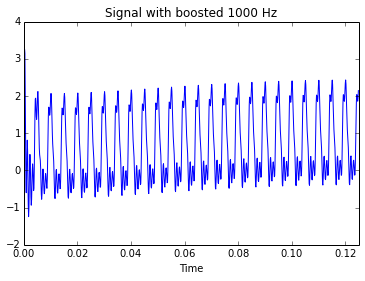

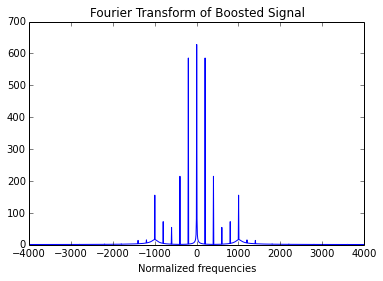

In [33]:
# Filtering
sig_accentuated=lfilter([1],a,x) #
plt.figure(10)
plt.plot(t,sig_accentuated)
plt.xlabel('Time')
plt.xlim([0, len(x)*Ts])
plt.title('Signal with boosted 1000 Hz')

# In the frequency domain
S_accentuated=fftshift(fft(sig_accentuated,1000))
plt.figure(11)
plt.plot(freq(1000,Fs),abs(S_accentuated))
plt.xlabel('Normalized frequencies')
plt.xlim([-Fs/2, Fs/2])
plt.title('Fourier Transform of Boosted Signal')

- How can we simultaneously boost around 1000 Hz and remove the drift?
Propose a filter that performs the two operations.


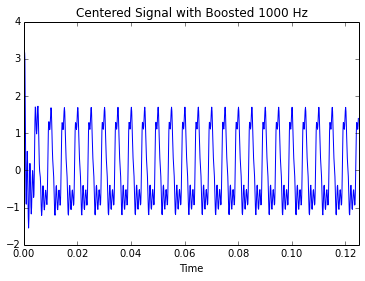

In [34]:
# both filterings: 
sig_accentuated_centered=lfilter(h,a,x) # 
plt.figure(12)
plt.plot(t,sig_accentuated_centered)
plt.xlabel('Time')
plt.xlim([0, len(x)*Ts])
plt.title('Centered Signal with Boosted 1000 Hz')

## Lowpass [0- 250 Hz] filtering  by the window method

>We want now to only keep the low-frequencies components  (0 
à 250 Hz) of $x_{c}$ by filtering with a lowpass 
FIR filter with $N$=101 coefficients. 
>
>##Theoretical Part
>
>We consider the ideal lowpass filter whose transfer function $H(f)$ (in modulus) is a rectangular function. Compute the (infinite support) impulse response of the associated digital filter.
>
>##Practical Part 
>
>a. We want to limit the number of coefficients to $L$ (FIR). We thus have to clip-off the initial impulse response. Compute the vector $h$ with $L$ coefficients corresponding to the initial response, windowed by a rectangular window rect$_{T}(t)$, where 
$T=L*Ts$.
>
>b. plt.plot the frequency response.
>
>c. Comput and plt.plot the output of this filter subject to the input 
$x_{c}$.
>
>d. Observe the group delay of the frequency response: `plt.plot(f,grpdelay(B,A,N))`. Comment.

### Theoretical Part

In [2]:
show_solution(1)


**Answers** For a rectangular window with width  $2B$, the inverse Fourier transform is
\begin{align}
h(n) & =\int_{[1]} \text{rect}_{2B}(f) e^{j2 \pi f n} \text{d}f \\ 
& = \int_{-B}^B  e^{j2 \pi f n} \text{d}f \\
& = B \frac{\sin(\pi B n)}{\pi B n}
\end{align}
The problems that appear are that

   - the impulse response $h(n)$ has infinite suppport
   - is  non-causal (defined for $t<0$)
   
So as to obtain an impulse response on $L$ points, it is thus necessary to

   - troncate the impulse response, and then
   - to delay it so as to obtain a causal response. 



### Practical part

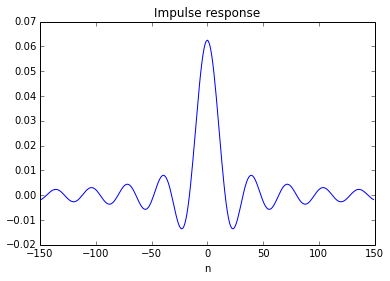

In [40]:
B=250
Fs=8000
B=B/Fs # Band in normalized fequencies
n=np.arange(-150,150)

def sinc(x):
    x=np.array(x)
    z=[sin(n)/n if n!=0 else 1 for n in x]
    return np.array(z)

#h=B*sin(pi*B*n)/(pi*B*n) # 
#h[0]=B
h=2*B*sinc(pi*2*B*n)
plt.plot(n,h)
plt.xlabel('n')
plt.title('Impulse response')

Trancation consists in keeping only the more interesting part; here, the samples between -50 and 50 (for a total of 101 points)

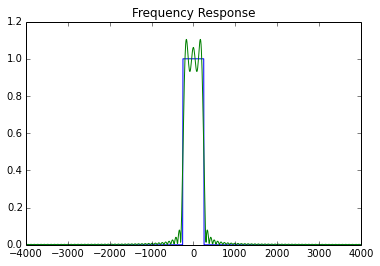

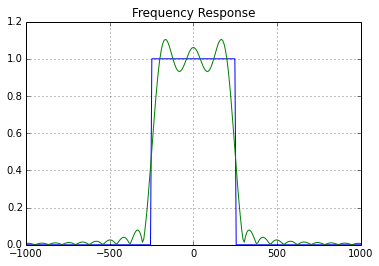

In [43]:
L=50
h_tronq=h=2*B*sinc(pi*2*B*np.arange(-L,L))
H_tronq=fft(h_tronq,1000)
f=(np.arange(1000)/1000-1/2)*8000
R=[1 if abs(ff)<250 else 0 for ff in f]
#
plt.figure()
plt.plot(f,R, f,abs(fftshift(H_tronq)))
plt.title("Frequency Response")
plt.figure()
plt.plot(f,R,f,abs(fftshift(H_tronq)))
plt.title("Frequency Response")
plt.xlim([-1000, 1000])
plt.grid(True)

### Output of the lowpass filter

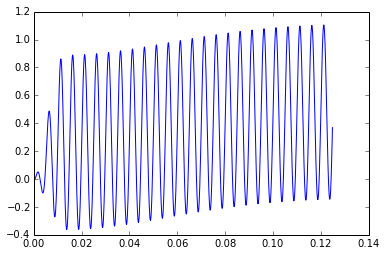

In [44]:
sig_lowpass=lfilter(h,[1],x) #
plt.plot(t,sig_lowpass)

### Group Delay

>The group delay is computed as indicated  [here](https://ccrma.stanford.edu/~jos/fp/Numerical_Computation_Group_Delay.html), cf https://ccrma.stanford.edu/~jos/fp/Numerical_Computation_Group_Delay.html

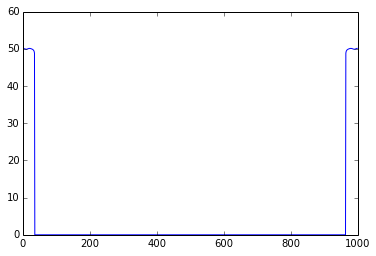

In [47]:
def grpdelay(h):
    N=len(h)
    NN=1000
    hn=h*np.arange(N)
    num=fft(hn.flatten(),NN)
    den=fft(h.flatten(),NN) 
    Mden=max(abs(den))
    #den[abs(den)<Mden/100]=1
    Td=real(num/den)
    Td[abs(den)<Mden/10]=0
    return num,den,Td
hh=zeros(200)
#hh[20:25]=array([1, -2, 70, -2, 1])
hh[24]=1
#plt.plot(grpdelay(hh))
num,den,Td=grpdelay(h_tronq)
plt.figure(3)
plt.plot(Td)

Thus we see that we have a group delay of about 50 in the band of the filter.

END.